Author: Samhita Sarikonda
Date: 2025-01-28

Description:
This assignment includes data preprocessing, index mapping, creation of positive and negative word pairs, building and training two models (a Logistic Regression version and a two-layer FFNN version), extracting embeddings, visualizing embeddings using t-SNE, and comparing the embeddings from the two systems.
    
Usage:
Run the script using Python 3. The script generates output log and accuracy files in the current directory.

In [23]:
# Installing all necessary libraries
!pip install emoji beautifulsoup4 nltk
!pip install --upgrade numpy==1.26.2 scipy==1.11.3

Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 24.3.1 -> 25.0
[notice] To update, run: pip install --upgrade pip
Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 24.3.1 -> 25.0
[notice] To update, run: pip install --upgrade pip


step 1: Data Preprocessing

1a:Pre-processing

In [1]:
#import all the necessary libraries
import os
import glob
import re
import random
import logging
from bs4 import BeautifulSoup
import emoji
import random
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score


In [2]:
# Function to load and preprocess text data from positive and negative directories.
def load_and_preprocess_data(positive_dir, negative_dir):
 
    
    all_tokens = []    
    original_lines = []  
    
    # Function to clean and tokenize a single text string.
    def preprocess_text(text):
        # Remove HTML tags from the text.
        text = BeautifulSoup(text, "html.parser").get_text()
        # Convert emojis to their text representation.
        text = emoji.demojize(text, delimiters=(" ", " "))
        # Replace the special symbol '@' with a space.
        text = text.replace('@', ' ')
        # Tokenize the text: match whole words or individual punctuation characters.
        tokens = re.findall(r'\b[A-Za-z0-9]+\b|[^\s\w]', text)
        
        processed_tokens = []
        for token in tokens:
    
            if re.fullmatch(r'[:;]-?[)(DP]', token):
                continue  
             # Keep only tokens that are purely alphabetic (removes punctuation and numbers).
            if not token.isalpha():
                continue
            # Lowercase tokens that start with a capital letter unless they are entirely uppercase (e.g., "USA").
            if token[0].isupper() and not token.isupper():
                token = token.lower()
            
            processed_tokens.append(token)
            
        return processed_tokens
    
    # Function to process a single file and collect its tokens.
    def preprocess_file(file_path):
        file_tokens = []
        with open(file_path, "r", encoding="utf-8") as file:
            for line in file:
         
                original_lines.append(line.strip())
            
                file_tokens.extend(preprocess_text(line))
        return file_tokens

    # Process all files in the positive directory.
    for file_path in glob.glob(os.path.join(positive_dir, "*.txt")):
        all_tokens.extend(preprocess_file(file_path))
    
    # Process all files in the negative directory.
    for file_path in glob.glob(os.path.join(negative_dir, "*.txt")):
        all_tokens.extend(preprocess_file(file_path))
    

    vocabulary = list(set(all_tokens))
    
    return vocabulary, all_tokens, original_lines

# Define directories for training data.
train_positive_dir = '/home/ssariko/PA1/PA1/tweet/train/positive'
train_negative_dir = '/home/ssariko/PA1/PA1/tweet/train/negative'

# Loading and preprocessing the data.
vocabulary, tokenized_data, original_data = load_and_preprocess_data(train_positive_dir, train_negative_dir)

# Display results for verification.
print("Vocabulary Size:", len(vocabulary))
print("Sample Tokens:", tokenized_data[:20])
print("Original Data Sample:", original_data[:5])

# Check for any noisy tokens (tokens that are not purely alphabetic).
noisy_tokens = [token for token in vocabulary if not token.isalpha()]
if noisy_tokens:
    print("Noisy Tokens Found:", noisy_tokens)
else:
    print("No noisy tokens found in the vocabulary!")

/opt/sw/spack/apps/linux-rhel8-x86_64_v2/gcc-10.3.0/python-3.9.9-jh/lib/python3.9/site-packages/bs4/__init__.py:431: MarkupResemblesLocatorWarning: "http://t.co/O0745APIau
" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  warnings.warn(
/opt/sw/spack/apps/linux-rhel8-x86_64_v2/gcc-10.3.0/python-3.9.9-jh/lib/python3.9/site-packages/bs4/__init__.py:431: MarkupResemblesLocatorWarning: "http://t.co/3fq3XElbOn
" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  warnings.warn(


Vocabulary Size: 6440
Sample Tokens: ['southwestair', 'I', 'would', 'appreciate', 'that', 'thank', 'you', 'usairways', 'thank', 'you', 'very', 'much', 'jetblue', 'I', 'm', 'all', 'set', 'about', 'to', 'fly']
Original Data Sample: ['@SouthwestAir I would appreciate that.  Thank you.', '@USAirways thank you very much.', "@JetBlue I'm all set. About to fly. Not bad for a first date with a giant metal bird machine. She even brought snacks.", '@SouthwestAir I got a flight at 11:55am on Thursday but looking for something tomorrow anything available?', "@AmericanAir you're my early frontrunner for best airline! #oscars2016"]
No noisy tokens found in the vocabulary!


1b: Word-to-Index and Index-to-Word Mapping

In [3]:
# Creating a dictionary that maps each token in the vocabulary to a unique integer index.
word_to_index = {word: i for i, word in enumerate(vocabulary)}

print("Sample Word-to-Index Mapping (first 10 items):")
# Print the first 10 items of the word-to-index dictionary for verification.
for word, index in list(word_to_index.items())[:10]:
    print(f"{word}: {index}")

# Create the reverse mapping from integer index back to token.
index_to_word = {i: word for word, i in word_to_index.items()}
# Print the first 10 items of the index-to-word dictionary for verification.
print("\nSample Index-to-Word Mapping (first 10 items):")
for index, word in list(index_to_word.items())[:10]:
    print(f"{index}: {word}")

Sample Word-to-Index Mapping (first 10 items):
cheapflights: 0
SEATAC: 1
expect: 2
adding: 3
sits: 4
dialing: 5
perhaps: 6
resolved: 7
TIME: 8
systems: 9

Sample Index-to-Word Mapping (first 10 items):
0: cheapflights
1: SEATAC
2: expect
3: adding
4: sits
5: dialing
6: perhaps
7: resolved
8: TIME
9: systems


1c, 1d: BUILD ALL PAIRS

In [4]:
# This function creates word pairs for a given token at a specified index.
# It generates positive pairs using a context window of size 'window_size' and generates negative pairs by sampling words outside the context window.
def find_word_pairs(tokens, index, window_size):
   
    pairs = []
    # Define the context window boundaries.
    start = max(0, index - window_size)
    end = min(len(tokens), index + window_size + 1)
    
    # Create positive pairs: for each word in the window (excluding the target itself),
    # pair it with the target and label the pair as positive (1).
    for j in range(start, end):
        if j == index:
            continue 
        pairs.append(((tokens[index], tokens[j]), 1))
    
    # For negative sampling: identify indices outside the context window.
    candidate_indices = list(range(0, start)) + list(range(end, len(tokens)))
    num_negatives = window_size * 2
    
    # Randomly sample from candidate indices to create negative pairs (label 0).
    if candidate_indices:
        negative_indices = random.choices(candidate_indices, k=num_negatives)
        for j in negative_indices:
            pairs.append(((tokens[index], tokens[j]), 0))
    
    return pairs

# This function iterates over all tokens to build all positive and negative pairs.
def build_all_pairs(tokens, window_size):
   
    all_pairs = []
    for i in range(len(tokens)):
        all_pairs.extend(find_word_pairs(tokens, i, window_size))
    return all_pairs

window_size = 2

# Build all word pairs from the tokenized data.
all_pairs = build_all_pairs(tokenized_data, window_size)

# Display a sample of the generated word pairs (first 20 items).
print("Sample pairs (first 20):")
for pair in all_pairs[:20]:
    print(pair)

Sample pairs (first 20):
(('southwestair', 'I'), 1)
(('southwestair', 'would'), 1)
(('southwestair', 'call'), 0)
(('southwestair', 'all'), 0)
(('southwestair', 'notifying'), 0)
(('southwestair', 'southwestair'), 0)
(('I', 'southwestair'), 1)
(('I', 'would'), 1)
(('I', 'appreciate'), 1)
(('I', 'I'), 0)
(('I', 'a'), 0)
(('I', 'gate'), 0)
(('I', 'over'), 0)
(('would', 'southwestair'), 1)
(('would', 'I'), 1)
(('would', 'appreciate'), 1)
(('would', 'that'), 1)
(('would', 'had'), 0)
(('would', 'the'), 0)
(('would', 'you'), 0)


BUILD AND TRAIN THE MODELS

In [5]:
# Define the vocabulary size and embedding dimension for our models.
vocab_size = len(vocabulary)  # Total number of unique tokens in the corpus.
embedding_dim = 50           # Each word will be represented by a 50-dimensional vector.

# Model 1: Logistic Regression version for Word2Vec
# This model uses two separate embedding layers (one for the target word and one for the context word).
# It concatenates these embeddings and passes them through a linear layer followed by a sigmoid activation.       

inputs_list = [[word_to_index[w1], word_to_index[w2]] for ((w1, w2), label) in all_pairs]
labels_list = [label for ((w1, w2), label) in all_pairs]
inputs = torch.tensor(inputs_list, dtype=torch.long)
targets = torch.tensor(labels_list, dtype=torch.float32)

class SimpleWord2Vec_LogiR(nn.Module):
    def __init__(self, vocab_size, embedding_dim):
        super(SimpleWord2Vec_LogiR, self).__init__()
        # Embedding layer for target words.
        self.embeddings_target = nn.Embedding(vocab_size, embedding_dim)
        # Embedding layer for context words.
        self.embeddings_context = nn.Embedding(vocab_size, embedding_dim)
         # Linear layer that takes concatenated embeddings.
        self.linear = nn.Linear(embedding_dim * 2, 1)
    
    def forward(self, target_indices, context_indices):
        # Retrieve embeddings for target and context words.
        target_embed = self.embeddings_target(target_indices) 
        context_embed = self.embeddings_context(context_indices)
        # Concatenate the two embeddings along the feature dimension.
        x = torch.cat([target_embed, context_embed], dim=1) 
        # Apply the linear layer and sigmoid activation to obtain a probability.
        out = torch.sigmoid(self.linear(x))
        return out

# Model 2: FFNN version for Word2Vec
# This model also uses two embedding layers but processes the concatenated embeddings through two hidden layers with ReLU activations before the final linear layer and sigmoid output.
class SimpleWord2Vec_FFNN(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_size=64):
        super(SimpleWord2Vec_FFNN, self).__init__()
        # Embedding layer for target words.
        self.embeddings_target = nn.Embedding(vocab_size, embedding_dim)
        # Embedding layer for context words.
        self.embeddings_context = nn.Embedding(vocab_size, embedding_dim)
        # First hidden layer.
        self.linear1 = nn.Linear(embedding_dim * 2, hidden_size)
        # Second hidden layer.
        self.linear2 = nn.Linear(hidden_size, hidden_size)
        # Output layer.
        self.linear3 = nn.Linear(hidden_size, 1)
    
    def forward(self, target_indices, context_indices):
        # Retrieve embeddings for target and context.
        target_embed = self.embeddings_target(target_indices)
        context_embed = self.embeddings_context(context_indices)
        # Concatenate the embeddings.
        x = torch.cat([target_embed, context_embed], dim=1)
        # Process through the hidden layers with ReLU activation.
        x = torch.relu(self.linear1(x))
        x = torch.relu(self.linear2(x))
        # Compute the final output and apply a sigmoid activation.
        out = torch.sigmoid(self.linear3(x))
        return out

# Instantiate both models with the defined vocabulary size and embedding dimension.
model_logir = SimpleWord2Vec_LogiR(vocab_size, embedding_dim)
model_ffnn = SimpleWord2Vec_FFNN(vocab_size, embedding_dim, hidden_size=64)

# Print the model architectures for verification.
print("Logistic Regression Model:")
print(model_logir)
print("\nFFNN Model:")
print(model_ffnn)


Logistic Regression Model:
SimpleWord2Vec_LogiR(
  (embeddings_target): Embedding(6440, 50)
  (embeddings_context): Embedding(6440, 50)
  (linear): Linear(in_features=100, out_features=1, bias=True)
)

FFNN Model:
SimpleWord2Vec_FFNN(
  (embeddings_target): Embedding(6440, 50)
  (embeddings_context): Embedding(6440, 50)
  (linear1): Linear(in_features=100, out_features=64, bias=True)
  (linear2): Linear(in_features=64, out_features=64, bias=True)
  (linear3): Linear(in_features=64, out_features=1, bias=True)
)


LOGISTIC REGRESSION MODEL WORD2VEC

Epoch 10 Loss = 0.7169459462165833
Epoch 20 Loss = 0.7081180810928345
Epoch 30 Loss = 0.7029479742050171
Epoch 40 Loss = 0.6997538208961487
Epoch 50 Loss = 0.6976954340934753
Epoch 60 Loss = 0.6963273882865906
Epoch 70 Loss = 0.6953968405723572
Epoch 80 Loss = 0.694753110408783
Epoch 90 Loss = 0.6943016648292542
Epoch 100 Loss = 0.6939815878868103


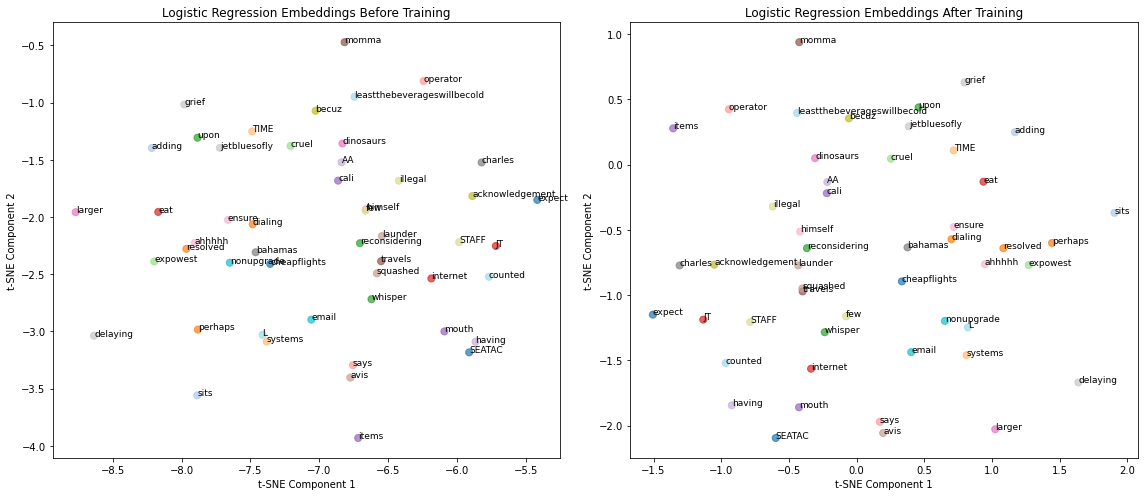

First 5 Training Inputs:
tensor([[ 348, 3424],
        [ 348, 3125],
        [ 348, 4066],
        [ 348, 5637],
        [ 348, 4285]])

First 5 Training Targets:
tensor([1., 1., 0., 0., 0.])

First 5 rows of Logistic Regression Model Target Embeddings:
tensor([[-5.8074e-01,  1.0068e+00,  2.4462e-01, -1.0529e-01,  1.3038e-01,
         -5.3125e-01, -5.5407e-01, -1.0981e+00,  1.1788e+00,  6.9940e-01,
          2.8631e-01, -1.6533e-01,  1.3372e-01,  1.9339e-01,  6.3414e-01,
          1.3640e+00, -4.1358e-01,  6.1913e-01, -1.4816e-02, -7.6965e-01,
          1.1844e+00, -2.5882e-01,  3.5154e-01,  3.7571e-01, -1.1003e+00,
          1.9344e+00,  5.7635e-01,  2.4702e+00, -8.9562e-01, -1.0178e+00,
         -3.9856e-01, -1.9837e+00, -1.4837e+00, -1.7189e+00, -5.5154e-01,
          6.4314e-02,  3.0528e-02,  8.3047e-01,  1.2176e+00,  9.5909e-01,
         -9.1096e-01,  2.1496e-01,  1.0901e+00,  6.1436e-02, -1.1530e+00,
         -7.5779e-01, -7.1358e-01,  1.4123e+00,  4.5226e-02,  6.6268e-01],
     

In [6]:
# Training function for the Logistic Regression model.
def train_logistic_regression(model, inputs, targets, lr=0.1, epochs=100):
    loss_function = nn.BCELoss()
    optimizer = optim.SGD(model.parameters(), lr=lr)
    losses = []
    for epoch in range(epochs):
        model.train()
        optimizer.zero_grad()
        outputs = model(inputs[:, 0], inputs[:, 1]).squeeze()  # Pass two separate inputs.
        loss = loss_function(outputs, targets)
        loss.backward()
        optimizer.step()
        losses.append(loss.item())
        if (epoch + 1) % 10 == 0:
            print("Epoch", epoch+1, "Loss =", loss.item())
    return model, losses

# Visualization function to apply t-SNE on embeddings before and after training.
def visualize_embeddings(embeddings_before, embeddings_after, word_to_index, title="Logistic Regression", num_words=50):
    emb_before_np = embeddings_before.cpu().detach().numpy()
    emb_after_np  = embeddings_after.cpu().detach().numpy()
    tsne = TSNE(n_components=2, random_state=42, perplexity=30, n_iter=1000)
    reduced_before = tsne.fit_transform(emb_before_np[:num_words])
    reduced_after  = tsne.fit_transform(emb_after_np[:num_words])
    index_to_word = {v: k for k, v in word_to_index.items()}
    fig, axes = plt.subplots(1, 2, figsize=(16, 7))
    for ax, reduced, stage in zip(axes, [reduced_before, reduced_after], ["Before Training", "After Training"]):
        scatter = ax.scatter(reduced[:, 0], reduced[:, 1], c=range(num_words), cmap="tab20", alpha=0.7, s=50)
        for i in range(num_words):
            word = index_to_word.get(i, "")
            ax.annotate(word, (reduced[i, 0], reduced[i, 1]), fontsize=9, color="black")
        ax.set_title(f"{title} Embeddings {stage}")
        ax.set_xlabel("t-SNE Component 1")
        ax.set_ylabel("t-SNE Component 2")
    plt.tight_layout()
    plt.show()

vocab_size = len(word_to_index)
embedding_dim = 50

# Instantiate the Logistic Regression model using the SimpleWord2Vec_LogiR class.
model_new = SimpleWord2Vec_LogiR(vocab_size, embedding_dim)

# Clone the initial target embeddings before training for later comparison.
embeddings_before = model_new.embeddings_target.weight.data.clone()

# Train the model using the training function.
trained_model, train_losses = train_logistic_regression(model_new, inputs, targets, lr=0.1, epochs=100)

# Clone the target embeddings after training.
embeddings_after = trained_model.embeddings_target.weight.data.clone()

# Visualize the embeddings before and after training using t-SNE.
visualize_embeddings(embeddings_before, embeddings_after, word_to_index, title="Logistic Regression", num_words=50)

# Display a sample of the training inputs and targets.
print("First 5 Training Inputs:")
print(inputs[:5])
print("\nFirst 5 Training Targets:")
print(targets[:5])
print("\nFirst 5 rows of Logistic Regression Model Target Embeddings:")
print(trained_model.embeddings_target.weight.data[:5])


FFNN FOR Word2Vec

Epoch 20/200, Loss = 0.6919
Epoch 40/200, Loss = 0.6898
Epoch 60/200, Loss = 0.6857
Epoch 80/200, Loss = 0.6790
Epoch 100/200, Loss = 0.6706
Epoch 120/200, Loss = 0.6620
Epoch 140/200, Loss = 0.6533
Epoch 160/200, Loss = 0.6444
Epoch 180/200, Loss = 0.6356
Epoch 200/200, Loss = 0.6267
Final training loss (FFNN): 0.626739501953125


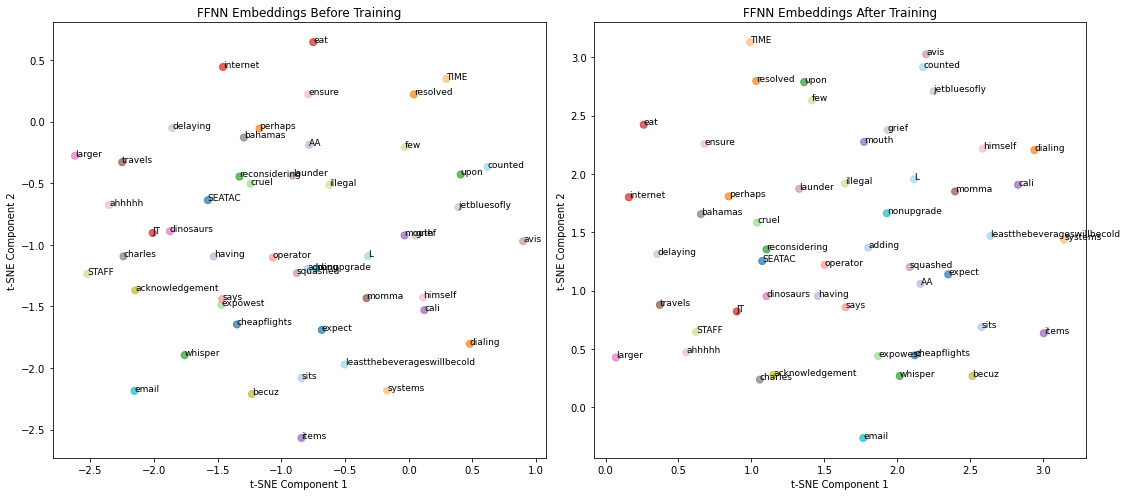

First 5 Training Inputs:
tensor([[ 348, 3424],
        [ 348, 3125],
        [ 348, 4066],
        [ 348, 5637],
        [ 348, 4285]])

First 5 Training Targets:
tensor([1., 1., 0., 0., 0.])

First 5 rows of FFNN Model Embeddings:
tensor([[ 1.3098e+00, -3.8017e-01,  8.7370e-01, -4.3040e-01,  4.1840e-01,
         -1.1209e+00, -9.5332e-02,  2.1182e+00,  7.3459e-01,  1.2515e+00,
         -5.2614e-01,  1.5731e-01, -7.1070e-01,  1.1163e+00,  1.9010e+00,
         -5.4623e-01, -6.1335e-01,  8.5220e-01,  1.0803e+00, -5.2348e-01,
          2.9958e-01, -5.7270e-01, -3.8640e-01,  1.7273e+00, -3.9375e-01,
         -4.2342e-01,  1.4321e+00,  6.5226e-01,  1.2641e-01, -1.2241e-01,
         -2.6206e-01,  8.9776e-02, -8.1623e-01, -9.4642e-01,  1.5805e+00,
         -1.6665e-02,  1.2406e+00, -1.5872e+00, -2.3755e-01,  1.3358e-01,
         -2.1372e-01, -1.6127e+00, -8.8689e-01,  9.9356e-01, -9.4139e-01,
         -6.8428e-01, -7.7432e-01,  1.1178e+00, -1.0487e+00, -4.7484e-01],
        [-2.9795e-01, -7.73

In [7]:
# Training Function for the FFNN Model Using Adam
def train_ffnn(model, inputs, targets, lr=0.001, epochs=200):
    # Use Binary Cross Entropy Loss for binary classification.
    loss_function = nn.BCELoss()
    # Use the Adam optimizer with the specified learning rate.
    optimizer = optim.Adam(model.parameters(), lr=lr)
    losses = []
    for epoch in range(epochs):
        model.train()
        optimizer.zero_grad()
        # Split the inputs tensor into target indices and context indices.
        target_indices = inputs[:, 0]
        context_indices = inputs[:, 1]
        outputs = model(target_indices, context_indices).squeeze()
        loss = loss_function(outputs, targets)
        loss.backward()
        optimizer.step()
        losses.append(loss.item())
        if (epoch + 1) % 20 == 0:
            print(f"Epoch {epoch+1}/{epochs}, Loss = {loss.item():.4f}")
    return model, losses

# Visualization Function for Embeddings (t-SNE)
def visualize_embeddings(embeddings_before, embeddings_after, word_to_index, title="FFNN", num_words=50):
    # Convert embedding tensors to NumPy arrays.
    emb_before_np = embeddings_before.cpu().detach().numpy()
    emb_after_np  = embeddings_after.cpu().detach().numpy()
     # Apply t-SNE to reduce dimensions to 2D.
    tsne = TSNE(n_components=2, random_state=42, perplexity=30, n_iter=1000)
    reduced_before = tsne.fit_transform(emb_before_np[:num_words])
    reduced_after  = tsne.fit_transform(emb_after_np[:num_words])
     # Create a reverse mapping from indices to words.
    index_to_word = {v: k for k, v in word_to_index.items()}
    fig, axes = plt.subplots(1, 2, figsize=(16, 7))
    for ax, reduced, stage in zip(axes, [reduced_before, reduced_after], ["Before Training", "After Training"]):
        scatter = ax.scatter(reduced[:, 0], reduced[:, 1], c=range(num_words), cmap="tab20", alpha=0.7, s=50)
        for i in range(num_words):
            word = index_to_word.get(i, "")
            ax.annotate(word, (reduced[i, 0], reduced[i, 1]), fontsize=9, color="black")
        ax.set_title(f"{title} Embeddings {stage}")
        ax.set_xlabel("t-SNE Component 1")
        ax.set_ylabel("t-SNE Component 2")
    plt.tight_layout()
    plt.show()

vocab_size = len(word_to_index)
embedding_dim = 50
model_ffnn = SimpleWord2Vec_FFNN(vocab_size, embedding_dim, hidden_size=64)

# Clone the initial embeddings before training for later comparison.
embeddings_before_ffnn = model_ffnn.embeddings_target.weight.data.clone()

# Train the FFNN model using the training function.
trained_ffnn, losses_ffnn = train_ffnn(model_ffnn, inputs, targets, lr=0.001, epochs=200)
print("Final training loss (FFNN):", losses_ffnn[-1])

# Clone the embeddings after training.
embeddings_after_ffnn = trained_ffnn.embeddings_target.weight.data.clone()

# Print a sample of the training data and the first 5 rows of the model's embeddings.
visualize_embeddings(embeddings_before_ffnn, embeddings_after_ffnn, word_to_index, title="FFNN", num_words=50)
print("First 5 Training Inputs:")
print(inputs[:5])
print("\nFirst 5 Training Targets:")
print(targets[:5])
print("\nFirst 5 rows of FFNN Model Embeddings:")
print(trained_ffnn.embeddings_target.weight.data[:5])


EVALUATION ON TEST DATA

In [8]:
# Function to Load and Prepare Test Data
def load_test_data(test_positive_dir, test_negative_dir, word_to_index):
    def preprocess_file(file_path):
        pairs = []
        with open(file_path, "r", encoding="utf-8") as file:
            for line in file:
                tokens = line.strip().split()
                if len(tokens) >= 2:
                    for i in range(len(tokens) - 1):
                        word1, word2 = tokens[i], tokens[i + 1]
                        if word1 in word_to_index and word2 in word_to_index:
                            pairs.append((word1, word2))
        return pairs
    # Process all positive test files.
    positive_pairs = []
    for file_name in os.listdir(test_positive_dir):
        file_path = os.path.join(test_positive_dir, file_name)
        positive_pairs.extend(preprocess_file(file_path))

    # Process all negative test files.
    negative_pairs = []
    for file_name in os.listdir(test_negative_dir):
        file_path = os.path.join(test_negative_dir, file_name)
        negative_pairs.extend(preprocess_file(file_path))

    # Combine pairs and create labels.
    test_data = positive_pairs + negative_pairs
    test_labels = [1] * len(positive_pairs) + [0] * len(negative_pairs)

    # Convert word pairs into tensor inputs using word_to_index.
    test_inputs = torch.tensor(
        [[word_to_index[w1], word_to_index[w2]] for w1, w2 in test_data],
        dtype=torch.long,
    )
    test_targets = torch.tensor(test_labels, dtype=torch.float32)

    return test_inputs, test_targets, test_data

# Evaluation function to compute model predictions and evaluation metrics.
def evaluate_model_with_metrics(model, test_inputs, test_targets, test_data, output_file):
    model.eval()
    with torch.no_grad():
        if hasattr(model, 'embeddings_context'):
            target_indices = test_inputs[:, 0]
            context_indices = test_inputs[:, 1]
            predictions = model(target_indices, context_indices).squeeze()
        else:
            predictions = model(test_inputs).squeeze()
        predicted_classes = (predictions >= 0.5).long()
    
    # Save predictions and the corresponding probability values to a file.
    with open(output_file, "w") as f:
        for word_pair, pred_prob, pred_class in zip(test_data, predictions.tolist(), predicted_classes.tolist()):
            f.write(f"{word_pair[0]} {word_pair[1]} {pred_prob:.4f} {pred_class}\n")
    
    accuracy = accuracy_score(test_targets, predicted_classes)
    precision = precision_score(test_targets, predicted_classes, zero_division=0)
    recall = recall_score(test_targets, predicted_classes, zero_division=0)
    f1 = f1_score(test_targets, predicted_classes, zero_division=0)
    
    print(f"Evaluation Metrics for {output_file}:")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")
    
    return accuracy, precision, recall, f1

test_positive_dir = '/home/ssariko/PA1/PA1/tweet/test/positive'
test_negative_dir = '/home/ssariko/PA1/PA1/tweet/test/negative'

# Loading the test data.
test_inputs, test_targets, test_data = load_test_data(test_positive_dir, test_negative_dir, word_to_index)
print("Test Inputs Shape:", test_inputs.shape)

# Evaluate the Logistic Regression model on the test data.
logistic_regression_output_file = "logistic_regression_results_new.txt"
logistic_regression_metrics = evaluate_model_with_metrics(
    trained_model, test_inputs, test_targets, test_data, logistic_regression_output_file
)

# Evaluate the trained FFNN model on the test data.
ffnn_output_file = "ffnn_results_new.txt"
ffnn_metrics = evaluate_model_with_metrics(
    trained_ffnn, test_inputs, test_targets, test_data, ffnn_output_file
)


Test Inputs Shape: torch.Size([38604, 2])
Evaluation Metrics for logistic_regression_results_new.txt:
Accuracy: 0.4915
Precision: 0.1923
Recall: 0.5253
F1 Score: 0.2816
Evaluation Metrics for ffnn_results_new.txt:
Accuracy: 0.4117
Precision: 0.1887
Recall: 0.6370
F1 Score: 0.2912


COMPARISON

Cosine Similarities for Sampled Words:
Word: ea              | Cosine Similarity: 0.0938
Word: auciello        | Cosine Similarity: 0.2834
Word: rico            | Cosine Similarity: -0.2375
Word: hollywood       | Cosine Similarity: -0.1341
Word: covering        | Cosine Similarity: -0.1322
Word: harbor          | Cosine Similarity: 0.0210
Word: unhappycustomer | Cosine Similarity: -0.1337
Word: superior        | Cosine Similarity: -0.2087
Word: bootbag         | Cosine Similarity: 0.2658
Word: bench           | Cosine Similarity: 0.4212
Word: popping         | Cosine Similarity: 0.2787
Word: efficient       | Cosine Similarity: 0.0336
Word: adore           | Cosine Similarity: 0.0560
Word: shit            | Cosine Similarity: -0.1926
Word: write           | Cosine Similarity: 0.1211
Word: storm           | Cosine Similarity: 0.1895
Word: utterly         | Cosine Similarity: 0.0154
Word: may             | Cosine Similarity: 0.0119
Word: ithica          | Cosine Similarity: 0.0518
Word:

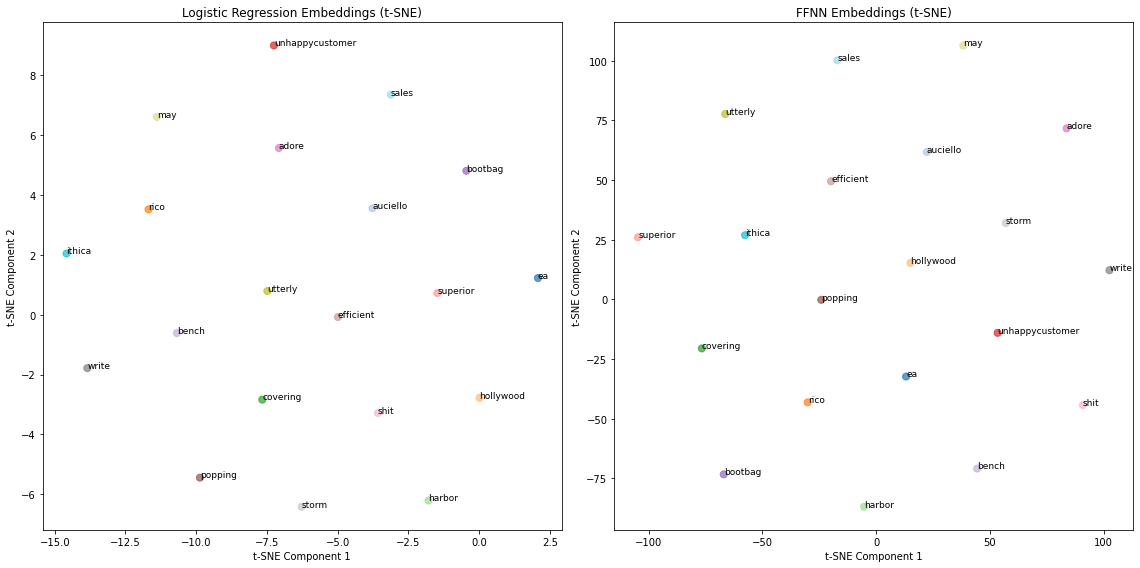

In [9]:
# Function to compare embeddings from two models using cosine similarity and t-SNE visualization.
def compare_embeddings(emb_logir, emb_ffnn, word_to_index, sample_size=20):
    # Ensure that the embeddings from both models have the same shape.
    if emb_logir.shape != emb_ffnn.shape:
        raise ValueError(f"Embeddings shapes do not match: "
                         f"Logistic Regression: {emb_logir.shape}, FFNN: {emb_ffnn.shape}")
    # Get a list of all indices from the vocabulary.
    all_indices = list(word_to_index.values())
    # Randomly sample a subset of indices to compare.
    sampled_indices = random.sample(all_indices, sample_size)
    similarities = []
    
    print("Cosine Similarities for Sampled Words:")
    for idx in sampled_indices:
        # Retrieve the word corresponding to the sampled index.
        word = next((w for w, i in word_to_index.items() if i == idx), None)
        # Get the embedding vectors from both models for the given index.
        vec_logir = emb_logir[idx]
        vec_ffnn = emb_ffnn[idx]
        # Compute the cosine similarity between the two embedding vectors.
        cosine_sim = F.cosine_similarity(vec_logir.unsqueeze(0), vec_ffnn.unsqueeze(0)).item()
        similarities.append(cosine_sim)
        print(f"Word: {word:15s} | Cosine Similarity: {cosine_sim:.4f}")
    
    # Calculate and display the average cosine similarity over the sampled words.
    avg_similarity = sum(similarities) / len(similarities)
    print(f"\nAverage Cosine Similarity over {sample_size} words: {avg_similarity:.4f}")
    
    # Prepare the sampled embeddings for t-SNE visualization.
    
    sampled_logir = emb_logir[sampled_indices].cpu().detach().numpy()
    sampled_ffnn = emb_ffnn[sampled_indices].cpu().detach().numpy()
    
    tsne = TSNE(n_components=2, random_state=42, perplexity=min(30, sample_size-1), n_iter=1000)
    reduced_logir = tsne.fit_transform(sampled_logir)
    reduced_ffnn = tsne.fit_transform(sampled_ffnn)
    
    # Create a reverse mapping to get words from indices.
    index_to_word = {v: k for k, v in word_to_index.items()}
    sampled_words = [index_to_word[i] for i in sampled_indices]
    
     # Plot the t-SNE 
    fig, axes = plt.subplots(1, 2, figsize=(16, 8))
    for ax, reduced, title in zip(axes, [reduced_logir, reduced_ffnn], ['Logistic Regression', 'FFNN']):
        scatter = ax.scatter(reduced[:, 0], reduced[:, 1], c=range(sample_size), cmap="tab20", alpha=0.7, s=50)
        for i, word in enumerate(sampled_words):
            ax.annotate(word, (reduced[i, 0], reduced[i, 1]), fontsize=9, color="black")
        ax.set_title(f"{title} Embeddings (t-SNE)")
        ax.set_xlabel("t-SNE Component 1")
        ax.set_ylabel("t-SNE Component 2")
    plt.tight_layout()
    plt.show()
    
    return similarities, avg_similarity

# Extract embeddings from both models. 
embeddings_logir = trained_model.embeddings_target.weight.data    
embeddings_ffnn = trained_ffnn.embeddings_target.weight.data   

# Compare embeddings for a random sample of 20 words.
sample_similarities, avg_similarity = compare_embeddings(embeddings_logir, embeddings_ffnn, word_to_index, sample_size=20)


The compare_embeddings function calculates the cosine similarity between the embeddings of a random sample of words as learned by two models: **The Logistic Regression model** (baseline model with a single linear layer) and **The FFNN model** (which includes additional hidden layers and non-linearities)
Cosine similarity values range from -1 to 1. Values close to 1 indicate that the two models have learned very similar embeddings for a given word. Lower or negative values indicate divergence in the learned representations.
Differences in the embeddings may be due to: 
Architectural Differences: The FFNN model's deeper, non-linear structure allows it to capture more complex relationships, while the Logistic Regression model learns simpler, more linear representations.
Training Dynamics: Variations in training (such as different optimizers, learning rates, or epochs) can lead to different convergence behaviors.
Data Effects: The way positive and negative pairs are generated and the overall data distribution may influence how the embeddings are shaped.
The t-SNE visualization provides an intuitive visual comparison of the embeddings for a sample of words. By looking at how the words cluster in 2D space for each model, we can gain insight into how similarly the models represent semantic relationships.
The average cosine similarity over the sample gives a quantitative measure of the overall similarity between the two systems representations.

**BONUS QUESTION: How would you improve the methods for both logistic regression and FFNN? Please implement one or two solutions and show your results.**

Epoch 10/100, Loss = 0.6626
Epoch 20/100, Loss = 0.6466
Epoch 30/100, Loss = 0.6378
Epoch 40/100, Loss = 0.6317
Epoch 50/100, Loss = 0.6269
Epoch 60/100, Loss = 0.6231
Epoch 70/100, Loss = 0.6209
Epoch 80/100, Loss = 0.6184
Epoch 90/100, Loss = 0.6163
Epoch 100/100, Loss = 0.6147


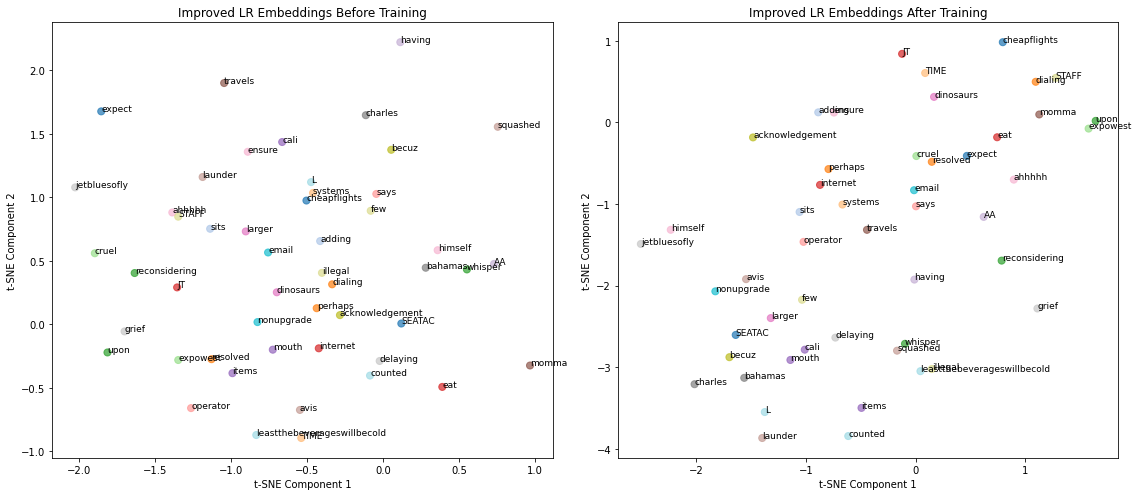

In [ ]:
# Improved Logistic Regression Model

class ImprovedLogisticRegression(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_size=32, dropout_prob=0.5):
        super(ImprovedLogisticRegression, self).__init__()
        self.embeddings = nn.Embedding(vocab_size, embedding_dim)
        self.hidden = nn.Linear(embedding_dim * 2, hidden_size)
        self.dropout = nn.Dropout(dropout_prob)
        self.fc = nn.Linear(hidden_size, 1)
        
    def forward(self, inputs):
        embedded_target = self.embeddings(inputs[:, 0])
        embedded_context = self.embeddings(inputs[:, 1])
        combined = torch.cat([embedded_target, embedded_context], dim=1)
        hidden_out = F.relu(self.hidden(combined))
        hidden_out = self.dropout(hidden_out)
        output = self.fc(hidden_out)
        return torch.sigmoid(output)

# Improved FFNN Model with Dropout
class ImprovedFFNN(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_size=64, dropout_prob=0.5):
        super(ImprovedFFNN, self).__init__()
        self.embeddings = nn.Embedding(vocab_size, embedding_dim)
        self.embeddings_context = nn.Embedding(vocab_size, embedding_dim)
        self.linear1 = nn.Linear(embedding_dim * 2, hidden_size)
        self.dropout1 = nn.Dropout(dropout_prob)
        self.linear2 = nn.Linear(hidden_size, hidden_size)
        self.dropout2 = nn.Dropout(dropout_prob)
        self.linear3 = nn.Linear(hidden_size, 1)
        
    def forward(self, target_indices, context_indices):
        target_embed = self.embeddings(target_indices)
        context_embed = self.embeddings_context(context_indices)
        x = torch.cat([target_embed, context_embed], dim=1)
        x = F.relu(self.linear1(x))
        x = self.dropout1(x)
        x = F.relu(self.linear2(x))
        x = self.dropout2(x)
        output = self.linear3(x)
        return torch.sigmoid(output)

# Training Function (Using Adam)

def train_model(model, inputs, targets, lr=0.001, epochs=100, batch_size=64):
    loss_function = nn.BCELoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)
    dataset_size = inputs.size(0)
    losses = []
    for epoch in range(epochs):
        model.train()
        permutation = torch.randperm(dataset_size)
        epoch_loss = 0.0
        for i in range(0, dataset_size, batch_size):
            indices = permutation[i:i+batch_size]
            batch_inputs = inputs[indices]
            batch_targets = targets[indices].unsqueeze(1).float()
            optimizer.zero_grad()
            if hasattr(model, 'embeddings_context'):
                outputs = model(batch_inputs[:, 0], batch_inputs[:, 1])
            else:
                outputs = model(batch_inputs)
            loss = loss_function(outputs, batch_targets)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item() * batch_inputs.size(0)
        avg_loss = epoch_loss / dataset_size
        losses.append(avg_loss)
        if (epoch+1) % 10 == 0:
            print(f"Epoch {epoch+1}/{epochs}, Loss = {avg_loss:.4f}")
    return model, losses

# Visualization Function for Embeddings (t-SNE)

def visualize_embeddings(embeddings_before, embeddings_after, word_to_index, title="Model", num_words=50):
    emb_before_np = embeddings_before.cpu().detach().numpy()
    emb_after_np  = embeddings_after.cpu().detach().numpy()
    tsne = TSNE(n_components=2, random_state=42, perplexity=30, n_iter=1000)
    reduced_before = tsne.fit_transform(emb_before_np[:num_words])
    reduced_after  = tsne.fit_transform(emb_after_np[:num_words])
    index_to_word = {v: k for k, v in word_to_index.items()}
    fig, axes = plt.subplots(1, 2, figsize=(16, 7))
    for ax, reduced, stage in zip(axes, [reduced_before, reduced_after], ["Before Training", "After Training"]):
        scatter = ax.scatter(reduced[:, 0], reduced[:, 1], c=range(num_words), cmap="tab20", alpha=0.7, s=50)
        for i in range(num_words):
            word = index_to_word.get(i, "")
            ax.annotate(word, (reduced[i, 0], reduced[i, 1]), fontsize=9, color="black")
        ax.set_title(f"{title} Embeddings {stage}")
        ax.set_xlabel("t-SNE Component 1")
        ax.set_ylabel("t-SNE Component 2")
    plt.tight_layout()
    plt.show()

inputs = torch.tensor([[word_to_index[w1], word_to_index[w2]] for ((w1, w2), label) in all_pairs], dtype=torch.long)
targets = torch.tensor([label for ((w1, w2), label) in all_pairs], dtype=torch.float32)

vocab_size = len(word_to_index)
embedding_dim = 50


# Train Improved Logistic Regression Model

improved_lr_model = ImprovedLogisticRegression(vocab_size, embedding_dim, hidden_size=32, dropout_prob=0.5)
embeddings_before_lr = improved_lr_model.embeddings.weight.data.clone()
improved_lr_model, lr_losses = train_model(improved_lr_model, inputs, targets, lr=0.001, epochs=100)
embeddings_after_lr = improved_lr_model.embeddings.weight.data.clone()

visualize_embeddings(embeddings_before_lr, embeddings_after_lr, word_to_index, title="Improved LR", num_words=50)


# Train Improved FFNN Model

improved_ffnn_model = ImprovedFFNN(vocab_size, embedding_dim, hidden_size=64, dropout_prob=0.5)
embeddings_before_ffnn = improved_ffnn_model.embeddings.weight.data.clone()
improved_ffnn_model, ffnn_losses = train_model(improved_ffnn_model, inputs, targets, lr=0.001, epochs=100)
embeddings_after_ffnn = improved_ffnn_model.embeddings.weight.data.clone()

visualize_embeddings(embeddings_before_ffnn, embeddings_after_ffnn, word_to_index, title="Improved FFNN", num_words=50)

print("First 5 Training Inputs:")
print(inputs[:5])
print("\nFirst 5 Training Targets:")
print(targets[:5])
print("\nFirst 5 rows of Improved LR Model Embeddings:")
print(improved_lr_model.embeddings.weight.data[:5])
print("\nFirst 5 rows of Improved FFNN Model Embeddings:")
print(improved_ffnn_model.embeddings.weight.data[:5])


Epoch 10/100, Loss = 0.6591
Epoch 20/100, Loss = 0.6448
Epoch 30/100, Loss = 0.6368
Epoch 40/100, Loss = 0.6308
Epoch 50/100, Loss = 0.6260
Epoch 60/100, Loss = 0.6221
Epoch 70/100, Loss = 0.6191
Epoch 80/100, Loss = 0.6165
Epoch 90/100, Loss = 0.6147
Epoch 100/100, Loss = 0.6133


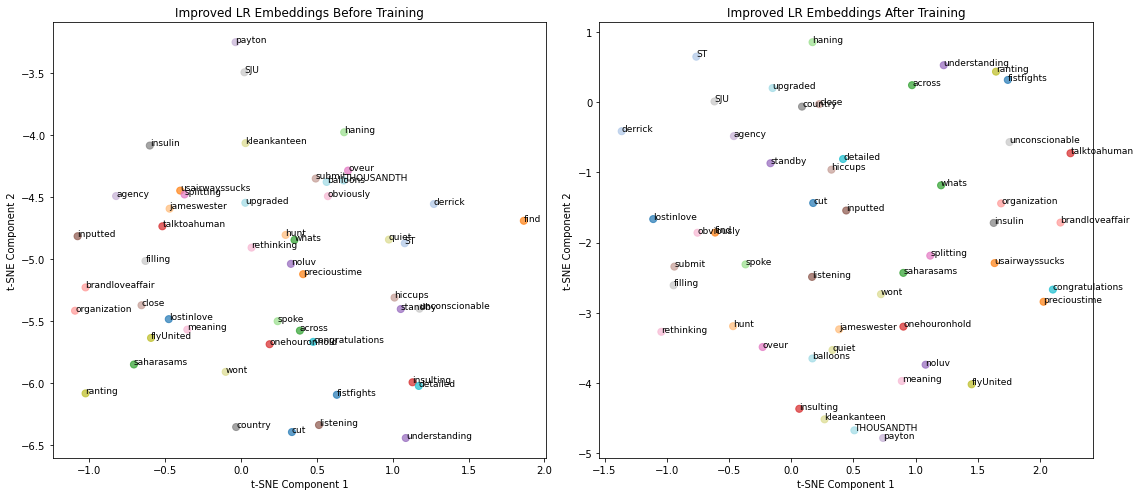

In [ ]:
# Improved Logistic Regression Model
# This model concatenates the target and context embeddings, processes them through a hidden layer with ReLU and dropout,
# and then produces a probability using a final linear layer followed by a sigmoid activation.
class ImprovedLogisticRegression(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_size=32, dropout_prob=0.5):
        super(ImprovedLogisticRegression, self).__init__()
        # Shared embedding layer for both target and context.
        self.embeddings = nn.Embedding(vocab_size, embedding_dim)
        # Hidden layer for non-linear interactions.
        self.hidden = nn.Linear(embedding_dim * 2, hidden_size)
        # Dropout for regularization.
        self.dropout = nn.Dropout(dropout_prob)
        # Final linear layer.
        self.fc = nn.Linear(hidden_size, 1)                 
        
    def forward(self, inputs):
        # Extract embeddings for target and context words.
        embedded_target = self.embeddings(inputs[:, 0])
        embedded_context = self.embeddings(inputs[:, 1])
        # Concatenate embeddings instead of averaging.
        combined = torch.cat([embedded_target, embedded_context], dim=1)
        hidden_out = F.relu(self.hidden(combined))
        hidden_out = self.dropout(hidden_out)
        output = self.fc(hidden_out)
        return torch.sigmoid(output)

# Improved FFNN Model with Dropout
# This model uses two separate embedding layers, concatenates them,
# and passes the result through two hidden layers with dropout before producing the output.
class ImprovedFFNN(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_size=64, dropout_prob=0.5):
        super(ImprovedFFNN, self).__init__()
        self.embeddings = nn.Embedding(vocab_size, embedding_dim)
        self.embeddings_context = nn.Embedding(vocab_size, embedding_dim)
        self.linear1 = nn.Linear(embedding_dim * 2, hidden_size)
        self.dropout1 = nn.Dropout(dropout_prob)
        self.linear2 = nn.Linear(hidden_size, hidden_size)
        self.dropout2 = nn.Dropout(dropout_prob)
        self.linear3 = nn.Linear(hidden_size, 1)
        
    def forward(self, target_indices, context_indices):
          # Retrieve embeddings for target and context.
        target_embed = self.embeddings(target_indices)
        context_embed = self.embeddings_context(context_indices)
        # Concatenate the embeddings.
        x = torch.cat([target_embed, context_embed], dim=1)
        x = F.relu(self.linear1(x))
        x = self.dropout1(x)
        x = F.relu(self.linear2(x))
        x = self.dropout2(x)
        output = self.linear3(x)
        return torch.sigmoid(output)

# Generic Training Function (Using Adam)
# This function trains a given model using Adam optimizer and binary cross-entropy loss.

def train_model(model, inputs, targets, lr=0.001, epochs=100, batch_size=64):
    loss_function = nn.BCELoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)
    dataset_size = inputs.size(0)
    losses = []
    for epoch in range(epochs):
        model.train()
        permutation = torch.randperm(dataset_size)
        epoch_loss = 0.0
        for i in range(0, dataset_size, batch_size):
            indices = permutation[i:i+batch_size]
            batch_inputs = inputs[indices]
            batch_targets = targets[indices].unsqueeze(1).float()
            optimizer.zero_grad()
            if hasattr(model, 'embeddings_context'):
                outputs = model(batch_inputs[:, 0], batch_inputs[:, 1])
            else:
                outputs = model(batch_inputs)
            loss = loss_function(outputs, batch_targets)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item() * batch_inputs.size(0)
        avg_loss = epoch_loss / dataset_size
        losses.append(avg_loss)
        if (epoch+1) % 10 == 0:
            print(f"Epoch {epoch+1}/{epochs}, Loss = {avg_loss:.4f}")
    return model, losses

# Visualization Function for Embeddings using t-SNE.
# This function reduces the dimensions of the embeddings before and after training and plots them side-by-side.

def visualize_embeddings(embeddings_before, embeddings_after, word_to_index, title="Model", num_words=50):
    emb_before_np = embeddings_before.cpu().detach().numpy()
    emb_after_np  = embeddings_after.cpu().detach().numpy()
    tsne = TSNE(n_components=2, random_state=42, perplexity=30, n_iter=1000)
    reduced_before = tsne.fit_transform(emb_before_np[:num_words])
    reduced_after  = tsne.fit_transform(emb_after_np[:num_words])
    index_to_word = {v: k for k, v in word_to_index.items()}
    fig, axes = plt.subplots(1, 2, figsize=(16, 7))
    for ax, reduced, stage in zip(axes, [reduced_before, reduced_after], ["Before Training", "After Training"]):
        scatter = ax.scatter(reduced[:, 0], reduced[:, 1], c=range(num_words), cmap="tab20", alpha=0.7, s=50)
        for i in range(num_words):
            word = index_to_word.get(i, "")
            ax.annotate(word, (reduced[i, 0], reduced[i, 1]), fontsize=9, color="black")
        ax.set_title(f"{title} Embeddings {stage}")
        ax.set_xlabel("t-SNE Component 1")
        ax.set_ylabel("t-SNE Component 2")
    plt.tight_layout()
    plt.show()

inputs = torch.tensor([[word_to_index[w1], word_to_index[w2]] for ((w1, w2), label) in all_pairs], dtype=torch.long)
targets = torch.tensor([label for ((w1, w2), label) in all_pairs], dtype=torch.float32)

vocab_size = len(word_to_index)
embedding_dim = 50


# Train Improved Logistic Regression Model

improved_lr_model = ImprovedLogisticRegression(vocab_size, embedding_dim, hidden_size=32, dropout_prob=0.5)
embeddings_before_lr = improved_lr_model.embeddings.weight.data.clone()
improved_lr_model, lr_losses = train_model(improved_lr_model, inputs, targets, lr=0.001, epochs=100)
embeddings_after_lr = improved_lr_model.embeddings.weight.data.clone()

visualize_embeddings(embeddings_before_lr, embeddings_after_lr, word_to_index, title="Improved LR", num_words=50)


# Train Improved FFNN Model

improved_ffnn_model = ImprovedFFNN(vocab_size, embedding_dim, hidden_size=64, dropout_prob=0.5)
embeddings_before_ffnn = improved_ffnn_model.embeddings.weight.data.clone()
improved_ffnn_model, ffnn_losses = train_model(improved_ffnn_model, inputs, targets, lr=0.001, epochs=100)
embeddings_after_ffnn = improved_ffnn_model.embeddings.weight.data.clone()

visualize_embeddings(embeddings_before_ffnn, embeddings_after_ffnn, word_to_index, title="Improved FFNN", num_words=50)

print("First 5 Training Inputs:")
print(inputs[:5])
print("\nFirst 5 Training Targets:")
print(targets[:5])
print("\nFirst 5 rows of Improved LR Model Embeddings:")
print(improved_lr_model.embeddings.weight.data[:5])
print("\nFirst 5 rows of Improved FFNN Model Embeddings:")
print(improved_ffnn_model.embeddings.weight.data[:5])


So, the improved models achieved lower training losses compared to the baselines. The improved Logistic Regression model dropped from ~0.695 to ~0.612, and the FFNN model showed a similar downward trend. These improvements—achieved through concatenating embeddings, adding hidden layers, using dropout, and employing the Adam optimizer—indicate that the enhanced architectures capture semantic relationships more effectively.